**Import Library**
---

In [1]:
# Import library
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

**Data Understanding**
---



Dataset ini digunakan untuk keperluan belajar. Anda dapat mengunduh dataset ini melalui web UCI Machine Learning repository berikut: https://archive.ics.uci.edu/ml/datasets/Restaurant+%26+consumer+data (alternatif: kaggle: https://www.kaggle.com/datasets/uciml/restaurant-data-with-consumer-ratings).

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00232/RCdata.zip
!unzip /content/RCdata.zip

--2025-06-08 14:53:45--  https://archive.ics.uci.edu/ml/machine-learning-databases/00232/RCdata.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘RCdata.zip’

RCdata.zip              [ <=>                ]  38.74K  --.-KB/s    in 0.05s   

2025-06-08 14:53:46 (757 KB/s) - ‘RCdata.zip’ saved [39674]

Archive:  /content/RCdata.zip
  inflating: chefmozaccepts.csv      
  inflating: chefmozcuisine.csv      
  inflating: chefmozhours4.csv       
  inflating: chefmozparking.csv      
  inflating: geoplaces2.csv          
  inflating: rating_final.csv        
  inflating: README                  
  inflating: usercuisine.csv         
  inflating: userpayment.csv         
  inflating: userprofile.csv         


Selanjutnya, mari kita baca data-data di atas dengan menggunakan fungsi pandas.read_csv. Implementasikan kode berikut.

In [3]:
accepts = pd.read_csv('/content/chefmozaccepts.csv')
cuisine = pd.read_csv('/content/chefmozcuisine.csv')
hours = pd.read_csv('/content/chefmozhours4.csv')
parking = pd.read_csv('/content/chefmozparking.csv')
geo = pd.read_csv('/content/geoplaces2.csv', encoding = "ISO-8859-1")
usercuisine = pd.read_csv('/content/usercuisine.csv')
payment = pd.read_csv('/content/userpayment.csv')
profile = pd.read_csv('/content/userprofile.csv')
rating = pd.read_csv('/content/rating_final.csv')

print('Jumlah data pembayaran yang diterima restoran: ', len(accepts.placeID.unique()))
print('Jumlah data masakan pada restoran: ', len(cuisine.placeID.unique()))
print('Jumlah data waktu buka restoran: ', len(hours.placeID.unique()))
print('Jumlah data lokasi restoran: ', len(geo.placeID.unique()))
print('Jumlah data masakan pengguna: ', len(usercuisine.userID.unique()))
print('Jumlah data profil pengguna: ', len(profile.userID.unique()))
print('Jumlah data penilaian yang diberikan pengguna: ', len(rating.userID.unique()))
print('Jumlah data penilaian restoran: ', len(rating.placeID.unique()))

Jumlah data pembayaran yang diterima restoran:  615
Jumlah data masakan pada restoran:  769
Jumlah data waktu buka restoran:  694
Jumlah data lokasi restoran:  130
Jumlah data masakan pengguna:  138
Jumlah data profil pengguna:  138
Jumlah data penilaian yang diberikan pengguna:  138
Jumlah data penilaian restoran:  130


Variabel-variabel pada Restaurant UCI dataset adalah sebagai berikut:

- accepts : merupakan jenis pembayaran yang diterima pada restoran tertentu.
- cuisine : merupakan jenis masakan yang disajikan pada restoran.
- hours : merupakan jadwal buka dan tutupnya restoran.
- parking : merupakan ketersediaan tempat parkir pada restoran.
- geo : merupakan letak restoran.
- usercuisine : merupakan jenis masakan dari data pengguna.
- payment : merupakan jenis pembayaran yang dipakai pengguna.
- profile : merupakan data profil pengguna.

Datanya memang tidak terlalu banyak karena kita hanya mengambil sampel berdasarkan placeID dan UserID. Namun, kita nanti akan melihat bagaimana data yang sedikit tetapi berkualitas bisa tetap memberikan rekomendasi yang baik. Selanjutnya, mari kita melakukan eksplorasi terhadap data dengan teknik univariate exploratory data analysis.

**EDA - Univariate Analysis**

Pertama, mari kita eksplorasi variabel accepts, yaitu jenis pembayaran yang diterima pada restoran tertentu. Implementasikan kode berikut.

In [4]:
accepts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314 entries, 0 to 1313
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   placeID   1314 non-null   int64 
 1   Rpayment  1314 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.7+ KB


Berdasarkan output di atas, kita dapat mengetahui bahwa file accept.csv memiliki 1314 entri. Ingatlah juga, accepts termasuk ke dalam kategori data Restaurant. Oleh karena itu, terdapat dua variabel di sini, yaitu placeID dan Rpayment. PlaceID merupakan ID restoran, sedangkan Rpayment merupakan jenis pembayaran yang digunakan pada restoran.


Untuk melihat ada berapa banyak entri yang unik berdasarkan placeID dan jenis-jenis pembayaran unik yang diterima, jalankan kode berikut.

In [5]:
print('Banyak data: ', len(accepts.placeID.unique()))
print('Jenis Pembayaran yang diterima: ', accepts.Rpayment.unique())

Banyak data:  615
Jenis Pembayaran yang diterima:  ['cash' 'VISA' 'MasterCard-Eurocard' 'American_Express' 'bank_debit_cards'
 'checks' 'Discover' 'Carte_Blanche' 'Diners_Club' 'Visa'
 'Japan_Credit_Bureau' 'gift_certificates']


Terdapat 615 data restoran yang unik dengan 12 jenis pembayaran yang diterima antara lain:

‘cash’, ‘VISA’, ‘MasterCard-Eurocard’, 'American_Express', 'bank_debit_cards', 'checks', 'Discover', 'Carte_Blanche', 'Diners_Club', 'Visa', 'Japan_Credit_Bureau', dan 'gift_certificates'.

Perhatikanlah, dari sebelumnya 1314 entri, setelah difilter dengan fungsi unique() datanya menjadi sejumlah 615.

Selanjutnya, mari kita eksplorasi variabel cuisine, yaitu jenis masakan yang tersedia di restoran. Mari kita lihat info variabel cuisine dengan menggunakan fungsi info().

In [6]:
cuisine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   placeID   916 non-null    int64 
 1   Rcuisine  916 non-null    object
dtypes: int64(1), object(1)
memory usage: 14.4+ KB


Untuk melihat jumlah tipe masakan (cuisine) dan nama-nama masakannya, mari kita kembali gunakan fungsi unique().

In [7]:
print('Banyak tipe masakan: ', len(cuisine.Rcuisine.unique()))
print('Tipe masakan: ', cuisine.Rcuisine.unique())

Banyak tipe masakan:  59
Tipe masakan:  ['Spanish' 'Italian' 'Latin_American' 'Mexican' 'Fast_Food' 'Burgers'
 'Dessert-Ice_Cream' 'Hot_Dogs' 'Steaks' 'Asian' 'International'
 'Mongolian' 'Vegetarian' 'Brazilian' 'Cafe-Coffee_Shop' 'Cafeteria'
 'Contemporary' 'Deli-Sandwiches' 'Diner' 'Japanese' 'Sushi' 'Seafood'
 'Chinese' 'Bar' 'Bar_Pub_Brewery' 'Pizzeria' 'Mediterranean' 'American'
 'Family' 'Caribbean' 'African' 'Breakfast-Brunch' 'Regional' 'Afghan'
 'Bakery' 'Game' 'Armenian' 'Vietnamese' 'Korean' 'Thai' 'Barbecue'
 'Polish' 'Dutch-Belgian' 'French' 'German' 'Southwestern' 'Persian'
 'Ethiopian' 'Juice' 'Soup' 'Continental-European' 'Greek' 'Southern'
 'Eastern_European' 'California' 'Bagels' 'Turkish' 'Organic-Healthy'
 'Fine_Dining']


Terdapat 59 tipe masakan yang berbeda dengan nama masakan seperti terlihat pada output kode.

Perhatikanlah, jenis-jenis masakan di atas. Pada modul selanjutnya kita akan gunakan data cuisine ini untuk memprediksi top-N rekomendasi bagi pengguna.

Seperti yang telah dibahas sebelumnya, profile pengguna kadang diperlukan untuk memahami pola preferensi terhadap suatu item. Pertama, kita lihat terlebih dahulu berapa jumlah kolom dan baris pada variabel profile.

In [8]:
print(profile.shape)

(138, 19)


Selanjutnya, mari kita lihat fitur apa saja yang terdapat pada variabel profile. Implementasikan kode berikut.

In [9]:
profile.head()

,userID,latitude,longitude,smoker,drink_level,dress_preference,ambience,transport,marital_status,hijos,birth_year,interest,personality,religion,activity,color,weight,budget,height
0,U1001,22.139997,-100.978803,false,abstemious,informal,family,on foot,single,independent,1989,variety,thrifty-protector,none,student,black,69,medium,1.77
1,U1002,22.150087,-100.983325,false,abstemious,informal,family,public,single,independent,1990,technology,hunter-ostentatious,Catholic,student,red,40,low,1.87
2,U1003,22.119847,-100.946527,false,social drinker,formal,family,public,single,independent,1989,none,hard-worker,Catholic,student,blue,60,low,1.69
3,U1004,18.867000,-99.183000,false,abstemious,informal,family,public,single,independent,1940,variety,hard-worker,none,professional,green,44,medium,1.53
4,U1005,22.183477,-100.959891,false,abstemious,no preference,family,public,single,independent,1992,none,thrifty-protector,Catholic,student,black,65,medium,1.69


Menarik. Kita mendapatkan berbagai data mulai dari marital_status, birth_year, smoker, religion, budget, dll. Jika kita ingin membangun sistem rekomendasi yang lebih kompleks, mungkin kita perlu menyertakan fitur-fitur di atas pada model. Data profile ini berguna jika kita ingin membuat sistem rekomendasi berdasarkan demografi atau kondisi sosial pengguna. Namun, untuk studi kasus kali ini, kita tidak akan menggunakan data profile pada model.

Pada latihan dengan content-based filtering nanti, data yang dibutuhkan adalah nama restoran dan cuisine. Kita akan menghitung kesamaan (similarity) cuisine dan nama restoran kemudian membuat rekomendasi berdasarkan kesamaan ini. Data-data ini dibutuhkan saat kita membuat sistem rekomendasi dengan teknik lain, misalnya, teknik yang melibatkan demografi.

Selanjutnya, mari kita eksplorasi data yang akan kita gunakan pada model yaitu data rating. Pertama, kita lihat seperti apa data pada variabel rating dengan fungsi head()

In [10]:
rating.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


Dari fungsi rating.head(), kita dapat mengetahui bahwa data rating terdiri dari 5 kolom dengan tiga kategori rating. Kolom-kolom tersebut antara lain:

- userID, merupakan identitas pengguna.
- placeID, merupakan identitas restoran.
- Rating, merupakan data rating untuk restoran.
- Food_rating, merupakan data rating untuk makanan atau masakan di restoran tersebut.
- Service_rating, merupakan data layanan restoran tersebut.

Nah, untuk melihat distribusi rating pada data, gunakan fungsi describe() dengan menerapkan kode berikut:

In [11]:
rating.describe()

,placeID,rating,food_rating,service_rating
count,1161.000000,1161.000000,1161.000000,1161.000000
mean,134192.041344,1.199828,1.215332,1.090439
std,1100.916275,0.773282,0.792294,0.790844
min,132560.000000,0.000000,0.000000,0.000000
25%,132856.000000,1.000000,1.000000,0.000000
50%,135030.000000,1.000000,1.000000,1.000000
75%,135059.000000,2.000000,2.000000,2.000000
max,135109.000000,2.000000,2.000000,2.000000


Dari output di atas, diketahui bahwa nilai maksimum rating adalah 2 dan nilai minimumnya adalah 0. Artinya, skala rating berkisar antara 0 hingga 2.

Untuk melihat berapa pengguna yang memberikan rating, jumlah restoran, dan jumlah rating, jalankan kode berikut.

In [12]:
print('Jumlah userID: ', len(rating.userID.unique()))
print('Jumlah placeID: ', len(rating.placeID.unique()))
print('Jumlah data rating: ', len(rating))

Jumlah userID:  138
Jumlah placeID:  130
Jumlah data rating:  1161


Sampai di tahap ini, kita telah memahami variabel-variabel pada data yang kita miliki.

Sekarang, mari kita gabungkan dataset agar dapat diproses untuk membuat sistem rekomendasi.

**Data Preprocessing - Menggabungkan Restoran**

Pertama, mari kita identifikasi berapa jumlah seluruh restoran pada dataset. Di sini, kita menggunakan library numpy dan fungsi concatenate untuk menggabungkan beberapa file. Pada materi sebelumnya, Anda mengetahui bahwa kesembilan file data kita dibagi ke dalam tiga kategori, yaitu: Restaurant, User, dan Rating. Nah, pada tahap ini, kita akan menggabungkan seluruh data pada kategori Restaurant. Sehingga, kita akan menggunakan placeID yang unik sebagai acuan dalam penggabungan ini. Implementasikan kode berikut.

In [13]:
import numpy as np

# Menggabungkan seluruh placeID pada kategori Restaurant
resto_all = np.concatenate((
    accepts.placeID.unique(),
    cuisine.placeID.unique(),
    hours.placeID.unique(),
    parking.placeID.unique(),
    geo.placeID.unique()
))

# Mengurutkan data dan menghapus data yang sama
resto_all = np.sort(np.unique(resto_all))

print('Jumlah seluruh data restoran berdasarkan placeID: ', len(resto_all))

Jumlah seluruh data restoran berdasarkan placeID:  938


Perhatikanlah, setelah file pada kategori Restaurant digabung, kita memiliki 938 restoran yang unik.

**Data Preprocessing - Menggabungkan Seluruh User**

Mari terapkan cara yang sama pada kategori variabel User. Dengan fungsi concatenate dari library numpy, gabungkan seluruh data pada kategori variabel User. Implementasikan kode berikut:

In [14]:
# Menggabungkan seluruh userID
user_all = np.concatenate((
    usercuisine.userID.unique(),
    payment.userID.unique(),
    profile.userID.unique()
))

# Menghapus data yang sama kemudian mengurutkannya
user_all = np.sort(np.unique(user_all))

print('Jumlah seluruh user: ', len(user_all))

Jumlah seluruh user:  138


Menurut Anda, apa yang menarik dari sini? Kita hanya memiliki 138 data pengguna dari 938 restoran yang memiliki rating.

**Data Preprocessing - Mengetahui Jumlah Rating**

Untuk mengetahui jumlah seluruh rating dari berbagai file, implementasikan kode berikut.

In [15]:
# Menggabungkan file accepts, geo, parking, hours ke dalam dataframe resto_info
resto_info = pd.concat([accepts, geo, parking, hours])

# Menggabungkan dataframe rating dengan resto_info berdasarkan nilai placeID
resto = pd.merge(rating, resto_info , on='placeID', how='left')
resto

,userID,placeID,rating,food_rating,service_rating,Rpayment,latitude,longitude,the_geom_meter,name,...,accessibility,price,url,Rambience,franchise,area,other_services,parking_lot,hours,days
0,U1077,135085,2,2,2,cash,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,U1077,135085,2,2,2,NaN,22.150802,-100.982680,0101000020957F00009F823DA6094858C18A2D4D37F9A4...,Tortas Locas Hipocampo,...,no_accessibility,medium,?,familiar,f,closed,none,NaN,NaN,NaN
2,U1077,135085,2,2,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,public,NaN,NaN
3,U1077,135085,2,2,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00-00:00;,Mon;Tue;Wed;Thu;Fri;
4,U1077,135085,2,2,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00-00:00;,Sat;
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8073,U1068,132660,0,0,0,NaN,23.752943,-99.164679,0101000020957F00003D7905C9DC8157C13FCD1AB7334E...,carnitas mata calle Emilio Portes Gil,...,completely,low,?,familiar,f,closed,none,NaN,NaN,NaN
8074,U1068,132660,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN
8075,U1068,132660,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00-23:30;,Mon;Tue;Wed;Thu;Fri;
8076,U1068,132660,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00-23:30;,Sat;


Variabel setelah dilakukan merge sangat banyak. Output di atas hanya menampilkan sebagian variabel saja. Perhatikanlah, kita memiliki banyak sekali missing value di sini. Mari kita cek lebih lanjut dengan kode berikut.

In [16]:
# Cek missing value dengan fungsi isnull()
resto.isnull().sum()

,0
userID,0
placeID,0
rating,0
food_rating,0
service_rating,0
Rpayment,5781
latitude,6917
longitude,6917
the_geom_meter,6917
name,6917


Terdapat banyak missing value pada sebagian besar fitur. Hanya fitur userID, placeID, rating, food_rating, dan service_rating saja yang memiliki 0 missing value. Selanjutnya, mari kita hitung jumlah rating, food_rating, dan service rating berdasarkan place.ID dengan kode berikut.

In [17]:
# Menghitung jumlah rating, food_rating, dan service kemudian menggabungkannya berdasarkan placeID
resto.groupby('placeID').sum()

,userID,rating,food_rating,service_rating,Rpayment,latitude,longitude,the_geom_meter,name,address,...,accessibility,price,url,Rambience,franchise,area,other_services,parking_lot,hours,days
placeID,,,,,,,,,,,,,,,,,,,,,
132560,U1067U1067U1067U1067U1067U1067U1082U1082U1082U...,12,24,6,cashcashcashcash,95.009216,-396.667653,0101000020957F0000FC60BDA8E88157C1B2C357D6DA4E...,puesto de gorditaspuesto de gorditaspuesto de ...,frente al tecnologicofrente al tecnologicofren...,...,no_accessibilityno_accessibilityno_accessibili...,lowlowlowlow,????,familiarfamiliarfamiliarfamiliar,ffff,openopenopenopen,nonenonenonenone,publicpublicpublicpublic,08:00-12:00;00:00-00:00;00:00-00:00;08:00-12:0...,Mon;Tue;Wed;Thu;Fri;Sat;Sun;Mon;Tue;Wed;Thu;Fr...
132561,U1026U1026U1026U1026U1026U1129U1129U1129U1129U...,15,20,20,0,94.907276,-396.506024,0101000020957F000004457BB7AA8657C15F10835CD944...,cafe ambarcafe ambarcafe ambarcafe ambar,????,...,completelycompletelycompletelycompletely,lowlowlowlow,????,familiarfamiliarfamiliarfamiliar,ffff,closedclosedclosedclosed,nonenonenonenone,nonenonenonenone,00:00-23:30;00:00-23:30;00:00-23:30;00:00-23:3...,Mon;Tue;Wed;Thu;Fri;Sat;Sun;Mon;Tue;Wed;Thu;Fr...
132564,U1060U1060U1060U1060U1060U1080U1080U1080U1080U...,25,25,30,0,94.923698,-396.580739,0101000020957F0000EA4F00C5A08557C140085474D949...,churchschurchschurchschurchs,????,...,completelycompletelycompletelycompletely,lowlowlowlow,????,familiarfamiliarfamiliarfamiliar,ffff,closedclosedclosedclosed,nonenonenonenone,nonenonenonenone,00:00-23:30;00:00-23:30;00:00-23:30;00:00-23:3...,Mon;Tue;Wed;Thu;Fri;Sat;Sun;Mon;Tue;Wed;Thu;Fr...
132572,U1108U1108U1108U1108U1108U1108U1055U1055U1055U...,90,90,84,cashcashcashcashcashcashcashcashcashcashcashca...,332.124707,-1514.890677,0101000020957F00005D19BF45294958C18FF7F8E260A8...,Cafe ChairesCafe ChairesCafe ChairesCafe Chair...,???????????????,...,completelycompletelycompletelycompletelycomple...,lowlowlowlowlowlowlowlowlowlowlowlowlowlowlow,???????????????,familiarfamiliarfamiliarfamiliarfamiliarfamili...,fffffffffffffff,closedclosedclosedclosedclosedclosedclosedclos...,nonenonenonenonenonenonenonenonenonenonenoneno...,yesyesyesyesyesyesyesyesyesyesyesyesyesyesyes,00:00-23:30;00:00-23:30;00:00-23:30;00:00-23:3...,Mon;Tue;Wed;Thu;Fri;Sat;Sun;Mon;Tue;Wed;Thu;Fr...
132583,U1044U1044U1044U1044U1044U1044U1118U1118U1118U...,24,24,30,cashVISAMasterCard-Eurocardbank_debit_cardscas...,75.689162,-396.937328,0101000020957F0000FBE7171F056F5AC1E8A6C0A5AF55...,McDonalds CentroMcDonalds CentroMcDonalds Cent...,Rayon sn col. CentroRayon sn col. CentroRayon ...,...,partiallypartiallypartiallypartially,lowlowlowlow,nononono,familiarfamiliarfamiliarfamiliar,tttt,closedclosedclosedclosed,nonenonenonenone,nonenonenonenone,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135088,U1044U1044U1044U1044U1044U1044U1030U1030U1030U...,36,42,36,cashcashcashcashcashcash,113.256068,-595.319338,0101000020957F0000E14AD4DBC7765AC1F7B33C85B153...,Cafeteria cenidetCafeteria cenidetCafeteria ce...,Interior Internado Palmira SNInterior Internad...,...,no_accessibilityno_accessibilityno_accessibili...,lowlowlowlowlowlow,www.cenidet.edu.mxwww.cenidet.edu.mxwww.cenide...,quietquietquietquietquietquiet,ffffff,closedclosedclosedclosedclosedclosed,nonenonenonenonenonenone,publicpublicpublicpublicpublicpublic,09:00-16:00;00:00-00:00;00:00-00:00;09:00-16:0...,Mon;Tue;Wed;Thu;Fri;Sat;Sun;Mon;Tue;Wed;Thu;Fr...
135104,U1068U1068U1068U1068U1068U1068U1068U1068U1067U...,48,80,48,cashVISAMasterCard-EurocardcashVISAMasterCard-...,166.270875,-694.179039,0101000020957F00007CDF5EAFC58157C1645743B23E4F...,vipsvipsvipsvipsvipsvipsvips,???????,...,completelycompletelycompletelycompletelycomple...,mediummediummediummediummediummediummedium,???????,familiarfamiliarfamiliarfamiliarfamiliarfamili...,ttttttt,closedclosedclosedclosedclosedclosedclosed,varietyvarietyvarietyvarietyvarietyvarietyvariety,yesyesyesyesyesyesyes,00:00-23:30;00:00-23:30;00:

**Data Preprocessing - Menggabungkan Data dengan Fitur Nama Resto**

Pertama, definisikan variabel all_resto_rate dengan variabel rating yang telah kita ketahui sebelumnya. Jalankan kode berikut.

In [18]:
# Definisikan dataframe rating ke dalam variabel all_resto_rate
all_resto_rate = rating
all_resto_rate

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2
...,...,...,...,...,...
1156,U1043,132630,1,1,1
1157,U1011,132715,1,1,0
1158,U1068,132733,1,1,0
1159,U1068,132594,1,1,1


Selanjutnya, untuk mengetahui nama restoran dengan placeID tertentu, mari kita gabungkan data geo yang berisikan placeID dan nama resto berdasarkan placeID dan assign ke variabel all_resto_name dengan fungsi merge dari library pandas.

In [19]:
# Menggabungkan all resto_rate dengan dataframe geo berdasarkan placeID
all_resto_name = pd.merge(all_resto_rate, geo[['placeID','name']], on='placeID', how='left')

# Print dataframe all_resto_name
all_resto_name

,userID,placeID,rating,food_rating,service_rating,name
0,U1077,135085,2,2,2,Tortas Locas Hipocampo
1,U1077,135038,2,2,1,Restaurant la Chalita
2,U1077,132825,2,2,2,puesto de tacos
3,U1077,135060,1,2,2,Restaurante Marisco Sam
4,U1068,135104,1,1,2,vips
...,...,...,...,...,...,...
1156,U1043,132630,1,1,1,palomo tec
1157,U1011,132715,1,1,0,tacos de la estacion
1158,U1068,132733,1,1,0,Little Cesarz
1159,U1068,132594,1,1,1,tacos de barbacoa enfrente del Tec


**Data Preprocessing - Menggabungkan Data dengan Fitur masakan Resto**

Langkah selanjutnya adalah menggabungkan variabel all_resto_name yang kita peroleh dari tahapan sebelumnya dengan fitur masakan resto (cuisine). Tujuannya, agar kita mengetahui masakan yang disediakan oleh restoran. Implementasikan kode berikut.

In [20]:
# Menggabungkan dataframe cuisine dengan all_resto_name dan memasukkannya ke dalam variabel all_resto
all_resto = pd.merge(all_resto_name, cuisine, on='placeID', how='left')
all_resto

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
0,U1077,135085,2,2,2,Tortas Locas Hipocampo,Fast_Food
1,U1077,135038,2,2,1,Restaurant la Chalita,NaN
2,U1077,132825,2,2,2,puesto de tacos,Mexican
3,U1077,135060,1,2,2,Restaurante Marisco Sam,Seafood
4,U1068,135104,1,1,2,vips,Mexican
...,...,...,...,...,...,...,...
1326,U1043,132630,1,1,1,palomo tec,Mexican
1327,U1011,132715,1,1,0,tacos de la estacion,Mexican
1328,U1068,132733,1,1,0,Little Cesarz,Pizzeria
1329,U1068,132594,1,1,1,tacos de barbacoa enfrente del Tec,Mexican


Inilah data yang akan kita gunakan untuk membuat sistem rekomendasi. Berikutnya, mari kita menuju tahapan Data Preparation.

**Data Preparation**
---



**Mengatasi Missing Value**

Setelah proses penggabungan, mari kita cek lagi datanya apakah ada missing value atau tidak. Jalankan kode berikut.

In [21]:
# Mengecek missing value pada dataframe all_resto
all_resto.isnull().sum()

,0
userID,0
placeID,0
rating,0
food_rating,0
service_rating,0
name,0
Rcuisine,288


Perhatikanlah, terdapat 288 missing value pada fitur ‘Rcuisine’ (kategori masakan). 288 dari 1331 merupakan jumlah yang signifikan. Sebenarnya sayang jika data missing value ini langsung di-drop begitu saja. Namun, kita tidak bisa mengidentifikasi nama masakan yang tidak memiliki data ‘Rcuisine’ ini termasuk ke dalam kategori masakan mana. Oleh karena itu, untuk saat ini kita akan drop saja missing value ini.

In [22]:
# Membersihkan missing value dengan fungsi dropna()
all_resto_clean = all_resto.dropna()
all_resto_clean

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
0,U1077,135085,2,2,2,Tortas Locas Hipocampo,Fast_Food
2,U1077,132825,2,2,2,puesto de tacos,Mexican
3,U1077,135060,1,2,2,Restaurante Marisco Sam,Seafood
4,U1068,135104,1,1,2,vips,Mexican
5,U1068,132740,0,0,0,Carreton de Flautas y Migadas,Mexican
...,...,...,...,...,...,...,...
1325,U1043,132732,1,1,1,Taqueria EL amigo,Mexican
1326,U1043,132630,1,1,1,palomo tec,Mexican
1327,U1011,132715,1,1,0,tacos de la estacion,Mexican
1328,U1068,132733,1,1,0,Little Cesarz,Pizzeria


Perhatikanlah, data kita sekarang memiliki 1043 baris. Untuk memastikan tidak ada missing value lagi dalam data, jalankan kode berikut.

In [23]:
# Mengecek kembali missing value pada variabel all_resto_clean
all_resto_clean.isnull().sum()

,0
userID,0
placeID,0
rating,0
food_rating,0
service_rating,0
name,0
Rcuisine,0


OK, sekarang data kita sudah bersih. Mari lanjutkan ke tahap berikutnya!

**Menyamakan Jenis masakan**

Sebelum masuk tahap akhir (pemodelan), kita perlu menyamakan nama masakan. Kadang, masakan yang sama memiliki nama atau kategori yang berbeda. Jika dibiarkan, hal ini bisa menyebabkan bias pada data. Sebagai contoh, pada data yang digunakan dalam studi kasus ini, Anda akan menemukan nama masakan ‘Game’. Anda tentu bertanya-tanya, jenis makanan apa ini? Nah, Anda akan menemukan jawabannya pada tahapan ini.  

Pertama, mari kita cek ulang data setelah proses cleaning pada tahap sebelumnya. Kita buat variabel baru bernama fix_resto untuk menyimpan dataframe.

In [24]:
# Mengurutkan resto berdasarkan PlaceID kemudian memasukkannya ke dalam variabel fix_resto
fix_resto = all_resto_clean.sort_values('placeID', ascending=True)
fix_resto

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
1288,U1050,132560,0,2,0,puesto de gorditas,Regional
42,U1082,132560,0,0,0,puesto de gorditas,Regional
1303,U1087,132560,1,2,1,puesto de gorditas,Regional
14,U1067,132560,1,0,0,puesto de gorditas,Regional
854,U1092,132572,1,0,0,Cafe Chaires,Cafeteria
...,...,...,...,...,...,...,...
189,U1055,135106,2,2,2,El Rincón de San Francisco,Mexican
1071,U1041,135109,1,2,1,Paniroles,Italian
99,U1030,135109,0,0,0,Paniroles,Italian
178,U1020,135109,2,2,1,Paniroles,Italian


Sekarang, kita memiliki 1043 baris data. Untuk mengecek berapa jumlah restoran yang mencakup data tersebut, jalankan kode berikut.

In [25]:
# Mengecek berapa jumlah fix_resto
len(fix_resto.placeID.unique())

95

Selanjutnya, mari kita cek Rcuisine (kategori masakan) yang unik dengan kode berikut.

In [26]:
# Mengecek kategori masakan yang unik
fix_resto.Rcuisine.unique()

array(['Regional', 'Cafeteria', 'American', 'Mexican', 'Fast_Food',
       'Italian', 'Armenian', 'Pizzeria', 'Japanese', 'Vietnamese',
       'Family', 'International', 'Game', 'Burgers', 'Bakery', 'Bar',
       'Breakfast-Brunch', 'Bar_Pub_Brewery', 'Mediterranean',
       'Cafe-Coffee_Shop', 'Contemporary', 'Seafood', 'Chinese'],
      dtype=object)

Perhatikanlah, di antara semua kategori masakan pada data, ada satu yang menarik, yaitu kategori masakan bernama ‘Game’. Hal-hal seperti ini kadang kita temukan pada data. Penyebabnya bisa beragam, misalnya, kesalahan input data atau perbedaan istilah di suatu daerah dengan daerah lainnya. Jika menemukan data seperti ini, hal yang perlu kita lakukan adalah mengeksplorasi datanya lebih lanjut dan melakukan analisis.

Dari proses analisis, kita akan memahami perbedaan penamaan ini terjadi pada data mana saja dan apa yang bisa kita lakukan untuk mengatasinya. Tentu solusi untuk permasalahan seperti ini akan berbeda tergantung kasusnya. Untuk kasus pada proyek ini, kita akan memilih salah satu penamaan kategori saja untuk digunakan pada data.

Nah, Anda tentu penasaran, restoran mana yang memiliki kategori ‘Game’? Mari kita lihat sama-sama.

In [27]:
# Mengecek kategori masakan Game
fix_resto[fix_resto['Rcuisine'] == 'Game']

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
781,U1015,132851,1,1,1,KFC,Game
708,U1008,132851,1,1,1,KFC,Game
509,U1052,132851,1,0,2,KFC,Game
1188,U1131,132851,2,2,2,KFC,Game
770,U1037,132851,2,2,1,KFC,Game
764,U1111,132851,2,1,0,KFC,Game
574,U1069,132851,1,0,0,KFC,Game


Ternyata, Game adalah masakan pada nama restoran KFC. Menarik. Pertanyaan selanjutnya, adakah kategori masakan (Rcuisine) lain untuk KFC? Mari kita cek.

In [28]:
# Mengecek kategori masakan pada nama restoran KFC
fix_resto[fix_resto['name'] == 'KFC']

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
573,U1069,132851,1,0,0,KFC,American
781,U1015,132851,1,1,1,KFC,Game
708,U1008,132851,1,1,1,KFC,Game
780,U1015,132851,1,1,1,KFC,American
763,U1111,132851,2,1,0,KFC,American
508,U1052,132851,1,0,2,KFC,American
509,U1052,132851,1,0,2,KFC,Game
1188,U1131,132851,2,2,2,KFC,Game
1187,U1131,132851,2,2,2,KFC,American
769,U1037,132851,2,2,1,KFC,American


Ada! Ternyata, KFC memiliki dua kategori masakan yang berbeda, ‘Game’ dan ‘American’. Tentu ini harus diperbaiki. Dalam sistem rekomendasi yang akan kita kembangkan, satu restoran memiliki satu kategori masakan. Dalam hal ini, KFC lebih cocok disebut sebagai restoran dengan kategori masakan American. Jadi, kita perlu mengganti kategori ‘Game’ dengan ‘American’.

Jalankan kode berikut.

In [29]:
# Mengubah nama kategori masakan ‘Game’ menjadi ‘American’
fix_resto = fix_resto.replace('Game', 'American')
fix_resto[fix_resto['name'] == 'KFC']

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
573,U1069,132851,1,0,0,KFC,American
781,U1015,132851,1,1,1,KFC,American
708,U1008,132851,1,1,1,KFC,American
780,U1015,132851,1,1,1,KFC,American
763,U1111,132851,2,1,0,KFC,American
508,U1052,132851,1,0,2,KFC,American
509,U1052,132851,1,0,2,KFC,American
1188,U1131,132851,2,2,2,KFC,American
1187,U1131,132851,2,2,2,KFC,American
769,U1037,132851,2,2,1,KFC,American


Bagus! Sekarang, semua kategori masakan ‘Game’ telah berubah menjadi ‘American’. Kini, restoran ‘KFC’ telah memiliki satu kategori masakan seperti yang kita harapkan, yaitu ‘American’. Dalam sistem rekomendasi yang kita kembangkan, penting untuk memastikan satu restoran mewakili satu kategori masakan. Tujuannya supaya tidak terjadi dobel atau rangkap kategori dalam satu restoran. Sehingga, sistem dapat merekomendasikan resto berdasarkan kategori masakannya.

Berikutnya, kita bisa melanjutkan ke tahap persiapan. Buatlah variabel bernama preparation. Jalankan kode berikut.

In [30]:
# Membuat variabel preparation yang berisi dataframe fix_resto kemudian mengurutkan berdasarkan placeID
preparation = fix_resto
preparation.sort_values('placeID')

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
1288,U1050,132560,0,2,0,puesto de gorditas,Regional
42,U1082,132560,0,0,0,puesto de gorditas,Regional
14,U1067,132560,1,0,0,puesto de gorditas,Regional
1303,U1087,132560,1,2,1,puesto de gorditas,Regional
1055,U1061,132572,1,2,2,Cafe Chaires,Cafeteria
...,...,...,...,...,...,...,...
189,U1055,135106,2,2,2,El Rincón de San Francisco,Mexican
1071,U1041,135109,1,2,1,Paniroles,Italian
99,U1030,135109,0,0,0,Paniroles,Italian
178,U1020,135109,2,2,1,Paniroles,Italian


Selanjutnya, kita hanya akan menggunakan data unik untuk dimasukkan ke dalam proses pemodelan. Oleh karena itu, kita perlu menghapus data yang duplikat dengan fungsi drop_duplicates(). Dalam hal ini, kita membuang data duplikat pada kolom ‘placeID’. Implementasikan kode berikut.

In [31]:
# Membuang data duplikat pada variabel preparation
preparation = preparation.drop_duplicates('placeID')
preparation

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
1288,U1050,132560,0,2,0,puesto de gorditas,Regional
854,U1092,132572,1,0,0,Cafe Chaires,Cafeteria
27,U1044,132583,1,2,1,McDonalds Centro,American
148,U1063,132584,2,1,1,Gorditas Dona Tota,Mexican
1304,U1087,132594,1,2,1,tacos de barbacoa enfrente del Tec,Mexican
...,...,...,...,...,...,...,...
1016,U1019,135086,0,0,0,Mcdonalds Parque Tangamanga,Burgers
179,U1051,135088,1,1,1,Cafeteria cenidet,Cafeteria
4,U1068,135104,1,1,2,vips,Mexican
807,U1135,135106,0,0,0,El Rincón de San Francisco,Mexican


Selanjutnya, kita perlu melakukan konversi data series menjadi list. Dalam hal ini, kita menggunakan fungsi tolist() dari library numpy. Implementasikan kode berikut.

In [32]:
# Mengonversi data series ‘placeID’ menjadi dalam bentuk list
resto_id = preparation['placeID'].tolist()

# Mengonversi data series ‘Name’ menjadi dalam bentuk list
resto_name = preparation['name'].tolist()

# Mengonversi data series ‘Rcuisine’ menjadi dalam bentuk list
resto_cuisine = preparation['Rcuisine'].tolist()

print(len(resto_id))
print(len(resto_name))
print(len(resto_cuisine))

95
95
95


Tahap berikutnya, kita akan membuat dictionary untuk menentukan pasangan key-value pada data resto_id, resto_name, dan resto_cuisine yang telah kita siapkan sebelumnya.

In [33]:
# Membuat dictionary untuk data ‘resto_id’, ‘resto_name’, dan ‘cuisine’
resto_new = pd.DataFrame({
    'id': resto_id,
    'resto_name': resto_name,
    'cuisine': resto_cuisine
})
resto_new

,id,resto_name,cuisine
0,132560,puesto de gorditas,Regional
1,132572,Cafe Chaires,Cafeteria
2,132583,McDonalds Centro,American
3,132584,Gorditas Dona Tota,Mexican
4,132594,tacos de barbacoa enfrente del Tec,Mexican
...,...,...,...
90,135086,Mcdonalds Parque Tangamanga,Burgers
91,135088,Cafeteria cenidet,Cafeteria
92,135104,vips,Mexican
93,135106,El Rincón de San Francisco,Mexican


Selamat! Data kini telah siap untuk dimasukkan ke dalam pemodelan. Yuk, kita lanjut ke tahap berikutnya!

**Modelling - Content Based Filtering**
---

Sampai di sini, Anda telah melewati serangkaian tahapan untuk membuat sistem rekomendasi mulai dari:

1. Data Understanding.
2. Univariate Exploratory Data Analysis.
3. Data Preprocessing.
4. Data Preparation.

Kini, saatnya Anda mengembangkan sistem rekomendasi dengan pendekatan content based filtering. Tapi sebelumnya, mari cek lagi data yang kita miliki dan assign dataframe dari tahap sebelumnya ke dalam variabel data, sebagai berikut:

In [34]:
data = resto_new
data.sample(5)

,id,resto_name,cuisine
75,135053,La Fontana Pizza Restaurante and Cafe,Fast_Food
12,132667,little pizza Emilio Portes Gil,Armenian
32,132854,Sirlone,International
44,132922,cafe punta del cielo,Cafeteria
36,132862,La Posada del Virrey,International


**TF-IDF Vectorizer**

Pada tahap ini, kita akan membangun sistem rekomendasi sederhana berdasarkan jenis masakan yang disediakan restoran. Anda telah belajar mengenai TF-IDF Vectorizer pada modul Sentiment Analysis. Teknik tersebut juga akan digunakan pada sistem rekomendasi untuk menemukan representasi fitur penting dari setiap kategori masakan.

Sama seperti proyek sentiment analysis, pada proyek ini, kita juga menggunakan fungsi tfidfvectorizer() dari library sklearn. Jalankan kode berikut

In [35]:
# Inisialisasi TfidfVectorizer
vectorizer = TfidfVectorizer()

# Melakukan perhitungan idf pada data cuisine
vectorizer.fit(data['cuisine'])

# Mapping array dari fitur index integer ke fitur nama
vectorizer.get_feature_names_out()

array(['american', 'armenian', 'bakery', 'bar', 'bar_pub_brewery',
       'breakfast', 'brunch', 'burgers', 'cafeteria', 'chinese',
       'contemporary', 'family', 'fast_food', 'international', 'italian',
       'japanese', 'mexican', 'pizzeria', 'regional', 'seafood',
       'vietnamese'], dtype=object)

Selanjutnya, lakukan fit dan transformasi ke dalam bentuk matriks.

In [36]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = vectorizer.fit_transform(data['cuisine'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(95, 21)

Perhatikanlah, matriks yang kita miliki berukuran (95, 22). Nilai 95 merupakan ukuran data dan 22 merupakan matrik kategori masakan.

Untuk menghasilkan vektor tf-idf dalam bentuk matriks, kita menggunakan fungsi todense(). Jalankan kode berikut.

In [37]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

Selanjutnya, mari kita lihat matriks tf-idf untuk beberapa resto (resto_name) dan kategori masakan (cuisine). Terapkan kode berikut.

In [38]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan jenis masakan
# Baris diisi dengan nama resto

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=vectorizer.get_feature_names_out(),
    index=data.resto_name
).sample(21, axis=1).sample(10, axis=0)

,mexican,brunch,cafeteria,bar,family,bar_pub_brewery,italian,seafood,chinese,international,...,armenian,bakery,american,pizzeria,contemporary,burgers,breakfast,fast_food,regional,japanese
resto_name,,,,,,,,,,,,,,,,,,,,,
tacos de la estacion,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
la parroquia,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.0
Restaurant de Mariscos de Picon,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Carls Jr,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0
Mikasa,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0
El Herradero Restaurante and Bar,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
La Posada del Virrey,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
carnitas_mata,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Kiku Cuernavaca,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0


Output matriks tf-idf di atas menunjukkan Carls Jr memiliki kategori burgers. Burgers Carls Jr, matriks menunjukan bahwa restoran tersebut merupakan resto dengan kategori burgers. Hal ini terlihat dari nilai matriks 1.0 pada kategori bar. Selanjutnya, restoran El Herradero Restaurante and Bar termasuk dalam kategori bar. Sedangkan, restorancarnitas_mata termasuk dalam kategori mexican. Demikian seterusnya.

**Cosine Similarity**

Pada tahap sebelumnya, kita telah berhasil mengidentifikasi korelasi antara restoran dengan kategori masakannya. Sekarang, kita akan menghitung derajat kesamaan (similarity degree) antar restoran dengan teknik cosine similarity. Di sini, kita menggunakan fungsi cosine_similarity dari library sklearn.

Jalankan kode berikut:

In [39]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Pada tahapan ini, kita menghitung cosine similarity dataframe tfidf_matrix yang kita peroleh pada tahapan sebelumnya. Dengan satu baris kode untuk memanggil fungsi cosine similarity dari library sklearn, kita telah berhasil menghitung kesamaan (similarity) antar restoran. Kode di atas menghasilkan keluaran berupa matriks kesamaan dalam bentuk array.

Selanjutnya, mari kita lihat matriks kesamaan setiap resto dengan menampilkan nama restoran dalam 5 sampel kolom (axis = 1) dan 10 sampel baris (axis=0). Jalankan kode berikut.

In [40]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama resto
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['resto_name'], columns=data['resto_name'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap resto
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (95, 95)


resto_name,little pizza Emilio Portes Gil,Michiko Restaurant Japones,Restaurant Familiar El Chino,Restaurant Wu Zhuo Yi,Gorditas Dona Tota
resto_name,,,,,
Mcdonalds Parque Tangamanga,0.0,0.0,0.0,0.0,0.0
El Rincon de San Francisco,0.0,0.0,0.0,0.0,1.0
Paniroles,0.0,0.0,0.0,0.0,0.0
Carls Jr,0.0,0.0,0.0,0.0,0.0
McDonalds Centro,0.0,0.0,0.0,0.0,0.0
Restaurant Las Mananitas,0.0,0.0,0.0,0.0,0.0
El Herradero Restaurante and Bar,0.0,0.0,0.0,0.0,0.0
Gordas de morales,0.0,0.0,0.0,0.0,1.0
Sirlone,0.0,0.0,0.0,0.0,0.0


Dengan cosine similarity, kita berhasil mengidentifikasi kesamaan antara satu restoran dengan restoran lainnya. Shape (95, 95) merupakan ukuran matriks similarity dari data yang kita miliki. Berdasarkan data yang ada, matriks di atas sebenarnya berukuran 95 restoran x 95 restoran (masing-masing dalam sumbu X dan Y). Artinya, kita mengidentifikasi tingkat kesamaan pada 95 nama restoran. Tapi tentu kita tidak bisa menampilkan semuanya. Oleh karena itu, kita hanya memilih 10 restoran pada baris vertikal dan 5 restoran pada sumbu horizontal seperti pada contoh di atas.

Nah, dengan data kesamaan (similarity) restoran yang diperoleh dari kode sebelumnya, kita akan merekomendasikan daftar resto yang mirip (similar) dengan resto yang sebelumnya pernah melayani pengguna. Yuk lanjut ke materi berikutnya!

**Mendapatkan Rekomendasi**

Sebelumnya, kita telah memiliki data similarity (kesamaan) antar restoran. Kini, tibalah saatnya  menghasilkan sejumlah restoran yang akan direkomendasikan kepada pengguna. Untuk lebih memahami bagaimana cara kerjanya, lihatlah kembali matriks similarity pada tahap sebelumnya. Sebagai gambaran, mari kita ambil satu contoh berikut.

Pengguna X pernah memesan makanan dari resto Palomo Tec. Kemudian, saat pengguna tersebut berencana untuk memesan makanan dari restoran lain, sistem akan merekomendasikan resto Gorditas Doa Gloria atau Gorditas Dona Tota. Nah, rekomendasi kedua restoran ini berdasarkan kesamaan yang dihitung dengan cosine similarity pada tahap sebelumnya.

Di sini, kita membuat fungsi resto_recommendations dengan beberapa parameter sebagai berikut:

- Nama_resto : Nama restoran (index kemiripan dataframe).
- Similarity_data : Dataframe mengenai similarity yang telah kita definisikan sebelumnya.
- Items : Nama dan fitur yang digunakan untuk mendefinisikan kemiripan, dalam hal ini adalah ‘resto_name’ dan ‘cuisine’.
- k : Banyak rekomendasi yang ingin diberikan.

Sebelum mulai menulis kodenya, ingatlah kembali definisi sistem rekomendasi yang menyatakan bahwa keluaran sistem ini adalah berupa top-N recommendation. Oleh karena itu, kita akan memberikan sejumlah rekomendasi restoran pada pengguna yang diatur dalam parameter k.

Jalankan kode berikut.

In [41]:
def resto_recommendations(nama_resto, similarity_data=cosine_sim_df, items=data[['resto_name', 'cuisine']], k=5):
    """
    Rekomendasi Resto berdasarkan kemiripan dataframe

    Parameter:
    ---
    nama_resto : tipe data string (str)
                Nama Restoran (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik, dengan resto sebagai
                      indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---


    Pada index ini, kita mengambil k dengan nilai similarity terbesar
    pada index matrix yang diberikan (i).
    """


    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,nama_resto].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop nama_resto agar nama resto yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(nama_resto, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

Perhatikanlah, dengan menggunakan argpartition, kita mengambil sejumlah nilai k tertinggi dari similarity data (dalam kasus ini: dataframe cosine_sim_df). Kemudian, kita mengambil data dari bobot (tingkat kesamaan) tertinggi ke terendah. Data ini dimasukkan ke dalam variabel closest. Berikutnya, kita perlu menghapus nama_resto yang yang dicari agar tidak muncul dalam daftar rekomendasi. Dalam kasus ini, nanti kita akan mencari resto yang mirip dengan KFC, sehingga kita perlu drop nama_resto KFC agar tidak muncul dalam daftar rekomendasi yang diberikan nanti.  

Selanjutnya, mari kita terapkan kode di atas untuk menemukan rekomendasi restoran yang mirip dengan KFC. Terapkan kode berikut:

In [42]:
data[data.resto_name.eq('KFC')]

,id,resto_name,cuisine
31,132851,KFC,American


Perhatikanlah, KFC masuk dalam kategori cuisine American. Tentu kita berharap rekomendasi yang diberikan adalah resto dengan kategori yang mirip. Nah, sekarang, dapatkan resto recommendation dengan memanggil fungsi yang telah kita definisikan sebelumnya:

In [43]:
# Mendapatkan rekomendasi restoran yang mirip dengan KFC
resto_recommendations('KFC')

,resto_name,cuisine
0,VIPS,American
1,tacos los volcanes,American
2,Pizzeria Julios,American
3,Sirlone,International
4,McDonalds Centro,American


Yay! Berhasil! Sistem kita memberikan rekomendasi 5 nama restoran dengan kategori ‘cuisine’ American dan satu kategori International. Bagaimana menurut Anda?

**Modelling - Collaborative Filtering**
---

**Data Understanding**

Pahami terlebih dahulu data rating yang kita miliki. Ingatlah saat Anda melakukan load data di awal dan membaca file rating_final.csv. Saat itu, Anda membuat variabel rating dan menetapkan data pada variabel tersebut. Untuk memudahkan supaya tidak tertukar dengan fitur ‘rating’ pada data, kita ubah nama variabel rating menjadi df.

In [44]:
# Membaca dataset

df = rating
df

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2
...,...,...,...,...,...
1156,U1043,132630,1,1,1
1157,U1011,132715,1,1,0
1158,U1068,132733,1,1,0
1159,U1068,132594,1,1,1


Perhatikanlah, data rating memiliki 1161 baris dan 5 kolom.

**Data Preparation**

Kini Anda memasuki tahap preprocessing. Pada tahap ini, Anda perlu melakukan persiapan data untuk menyandikan (encode) fitur ‘user’ dan ‘placeID’ ke dalam indeks integer. Terapkan kode berikut.

In [45]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = df['userID'].unique().tolist()
print('list userID: ', user_ids)

# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

list userID:  ['U1077', 'U1068', 'U1067', 'U1103', 'U1107', 'U1044', 'U1070', 'U1031', 'U1082', 'U1023', 'U1060', 'U1015', 'U1123', 'U1021', 'U1026', 'U1083', 'U1108', 'U1012', 'U1093', 'U1030', 'U1066', 'U1127', 'U1017', 'U1100', 'U1133', 'U1118', 'U1072', 'U1080', 'U1063', 'U1074', 'U1117', 'U1020', 'U1051', 'U1055', 'U1053', 'U1035', 'U1064', 'U1081', 'U1001', 'U1014', 'U1088', 'U1056', 'U1134', 'U1106', 'U1126', 'U1124', 'U1018', 'U1125', 'U1119', 'U1076', 'U1022', 'U1094', 'U1116', 'U1105', 'U1075', 'U1007', 'U1115', 'U1024', 'U1132', 'U1005', 'U1120', 'U1004', 'U1037', 'U1052', 'U1036', 'U1038', 'U1071', 'U1114', 'U1084', 'U1049', 'U1019', 'U1069', 'U1113', 'U1104', 'U1079', 'U1045', 'U1009', 'U1016', 'U1047', 'U1095', 'U1034', 'U1078', 'U1099', 'U1008', 'U1040', 'U1121', 'U1110', 'U1042', 'U1013', 'U1054', 'U1111', 'U1128', 'U1062', 'U1101', 'U1135', 'U1032', 'U1048', 'U1092', 'U1085', 'U1109', 'U1102', 'U1098', 'U1046', 'U1122', 'U1138', 'U1033', 'U1089', 'U1003', 'U1091', 'U10

Selanjutnya, lakukan hal yang sama pada fitur ‘placeID’.

In [46]:
# Mengubah placeID menjadi list tanpa nilai yang sama
resto_ids = df['placeID'].unique().tolist()

# Melakukan proses encoding placeID
resto_to_resto_encoded = {x: i for i, x in enumerate(resto_ids)}

# Melakukan proses encoding angka ke placeID
resto_encoded_to_resto = {i: x for i, x in enumerate(resto_ids)}

Berikutnya, petakan userID dan placeID ke dataframe yang berkaitan.

In [47]:
# Mapping userID ke dataframe user
df['user'] = df['userID'].map(user_to_user_encoded)

# Mapping placeID ke dataframe resto
df['resto'] = df['placeID'].map(resto_to_resto_encoded)

Terakhir, cek beberapa hal dalam data seperti jumlah user, jumlah resto, dan mengubah nilai rating menjadi float.

In [48]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah resto
num_resto = len(resto_encoded_to_resto)
print(num_resto)

# Mengubah rating menjadi nilai float
df['rating'] = df['rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(df['rating'])

# Nilai maksimal rating
max_rating = max(df['rating'])

print('Number of User: {}, Number of Resto: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_resto, min_rating, max_rating
))

138
130
Number of User: 138, Number of Resto: 130, Min Rating: 0.0, Max Rating: 2.0


Tahap persiapan telah selesai. Berikut adalah hal-hal yang telah kita lakukan pada tahap ini:

- Memahami data rating yang kita miliki.
- Menyandikan (encode) fitur ‘user’ dan ‘placeID’ ke dalam indeks integer.
- Memetakan ‘userID’ dan ‘placeID’ ke dataframe yang berkaitan.
- Mengecek beberapa hal dalam data seperti jumlah user, jumlah resto, kemudian mengubah nilai rating menjadi float.

Tahap persiapan ini penting dilakukan agar data siap digunakan untuk
pemodelan. Namun sebelumnya, kita perlu membagi data untuk training dan validasi terlebih dahulu yang akan kita pelajari di materi berikutnya. Tunggu apalagi, yuk kita lanjutkan.

**Membagi Data untuk Training dan Validasi**

Anda tentu sudah menduga, pada tahap ini kita akan melakukan pembagian data menjadi data training dan validasi. Betul! Namun sebelumnya, acak datanya terlebih dahulu agar distribusinya menjadi random..

In [49]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df

,userID,placeID,rating,food_rating,service_rating,user,resto
538,U1052,132870,1.0,1,1,63,116
673,U1015,132869,2.0,2,2,11,115
578,U1047,132875,0.0,0,0,78,117
242,U1056,135076,2.0,2,2,41,71
1063,U1002,135106,1.0,1,1,125,64
...,...,...,...,...,...,...,...
1044,U1073,135065,0.0,0,0,123,94
1095,U1058,135062,2.0,2,2,124,76
1130,U1087,132660,1.0,1,0,132,14
860,U1029,132937,1.0,1,1,110,126


Selanjutnya, kita bagi data train dan validasi dengan komposisi 80:20. Namun sebelumnya, kita perlu memetakan (mapping) data user dan resto menjadi satu value terlebih dahulu. Lalu, buatlah rating dalam skala 0 sampai 1 agar mudah dalam melakukan proses training.

In [50]:
# Membuat variabel x untuk mencocokkan data user dan resto menjadi satu value
x = df[['user', 'resto']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 63 116]
 [ 11 115]
 [ 78 117]
 ...
 [132  14]
 [110 126]
 [129   6]] [0.5 1.  0.  ... 0.5 0.5 0. ]


Data telah siap untuk dimasukkan ke dalam model. Yuk lanjut ke materi berikutnya!

**Evaluasi**
---

Pada tahap ini, model menghitung skor kecocokan antara pengguna dan resto dengan teknik embedding. Pertama, kita melakukan proses embedding terhadap data user dan resto. Selanjutnya, lakukan operasi perkalian dot product antara embedding user dan resto. Selain itu, kita juga dapat menambahkan bias untuk setiap user dan resto. Skor kecocokan ditetapkan dalam skala [0,1] dengan fungsi aktivasi sigmoid.

Di sini, kita membuat class RecommenderNet dengan keras Model class. Kode class RecommenderNet ini terinspirasi dari tutorial dalam situs Keras dengan beberapa adaptasi sesuai kasus yang sedang kita selesaikan. Terapkan kode berikut.

In [51]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_resto, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_resto = num_resto
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.resto_embedding = layers.Embedding( # layer embeddings resto
        num_resto,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.resto_bias = layers.Embedding(num_resto, 1) # layer embedding resto bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    resto_vector = self.resto_embedding(inputs[:, 1]) # memanggil layer embedding 3
    resto_bias = self.resto_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_resto = tf.tensordot(user_vector, resto_vector, 2)

    x = dot_user_resto + user_bias + resto_bias

    return tf.nn.sigmoid(x) # activation sigmoid

Selanjutnya, lakukan proses compile terhadap model.

In [52]:
model = RecommenderNet(num_users, num_resto, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Model ini menggunakan Binary Crossentropy untuk menghitung loss function, Adam (Adaptive Moment Estimation) sebagai optimizer, dan root mean squared error (RMSE) sebagai metrics evaluation.

Langkah berikutnya, mulailah proses training.

In [53]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.7042 - root_mean_squared_error: 0.4059 - val_loss: 0.6807 - val_root_mean_squared_error: 0.3933
Epoch 2/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6807 - root_mean_squared_error: 0.4013 - val_loss: 0.6772 - val_root_mean_squared_error: 0.3911
Epoch 3/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6724 - root_mean_squared_error: 0.3846 - val_loss: 0.6722 - val_root_mean_squared_error: 0.3880
Epoch 4/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.6456 - root_mean_squared_error: 0.3785 - val_loss: 0.6683 - val_root_mean_squared_error: 0.3855
Epoch 5/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6509 - root_mean_squared_error: 0.3684 - val_loss: 0.6635 - val_root_mean_squared_error: 0.3825
Epoch 6/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6368 - root_mean_squared_error: 0.3641 - val_loss: 0.6591 - val_root_mean_squared_error: 0.3797
Epoch 7/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s

**Visualisasi Metrik**

Untuk melihat visualisasi proses training, mari kita plot metrik evaluasi dengan matplotlib. Terapkan kode berikut.

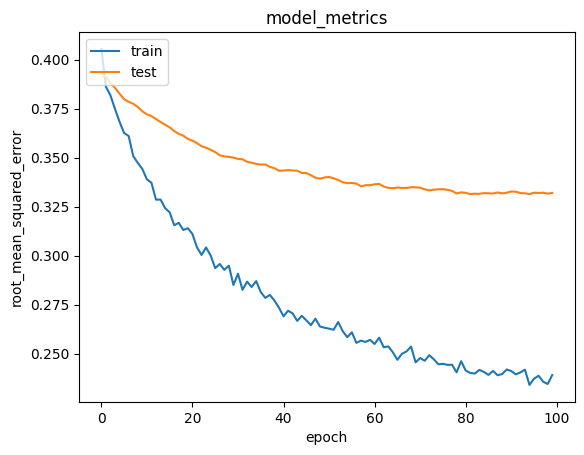

In [54]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Perhatikanlah, proses training model cukup smooth dan model konvergen pada epochs sekitar 100. Dari proses ini, kita memperoleh nilai error akhir sebesar sekitar 0.23 dan error pada data validasi sebesar 0.34. Nilai tersebut cukup bagus untuk sistem rekomendasi. Mari kita cek, apakah model ini bisa membuat rekomendasi dengan baik?

**Mendapatkan Rekomendasi Resto**

Untuk mendapatkan rekomendasi resto, pertama kita ambil sampel user secara acak dan definisikan variabel resto_not_visited yang merupakan daftar resto yang belum pernah dikunjungi oleh pengguna. Anda mungkin bertanya-tanya, mengapa kita perlu menentukan daftar resto_not_visited? Hal ini karena daftar resto_not_visited inilah yang akan menjadi resto yang kita rekomendasikan.

Sebelumnya, pengguna telah memberi rating pada beberapa resto yang telah mereka kunjungi. Kita menggunakan rating ini untuk membuat rekomendasi restoran yang mungkin cocok untuk pengguna. Nah, restoran yang akan direkomendasikan tentulah restoran yang belum pernah dikunjungi oleh pengguna. Oleh karena itu, kita perlu membuat variabel resto_not_visited sebagai daftar restoran untuk direkomendasikan pada pengguna.

Variabel resto_not_visited diperoleh dengan menggunakan operator bitwise (~) pada variabel resto_visited_by_user.

Terapkan kode berikut.

In [55]:
resto_df = resto_new
df = pd.read_csv('rating_final.csv')

# Mengambil sample user
user_id = df.userID.sample(1).iloc[0]
resto_visited_by_user = df[df.userID == user_id]

# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
resto_not_visited = resto_df[~resto_df['id'].isin(resto_visited_by_user.placeID.values)]['id']
resto_not_visited = list(
    set(resto_not_visited)
    .intersection(set(resto_to_resto_encoded.keys()))
)

resto_not_visited = [[resto_to_resto_encoded.get(x)] for x in resto_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_resto_array = np.hstack(
    ([[user_encoder]] * len(resto_not_visited), resto_not_visited)
)

Selanjutnya, untuk memperoleh rekomendasi restoran, gunakan fungsi model.predict() dari library Keras dengan menerapkan kode berikut.

In [56]:
ratings = model.predict(user_resto_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_resto_ids = [
    resto_encoded_to_resto.get(resto_not_visited[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Resto with high ratings from user')
print('----' * 8)

top_resto_user = (
    resto_visited_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .placeID.values
)

resto_df_rows = resto_df[resto_df['id'].isin(top_resto_user)]
for row in resto_df_rows.itertuples():
    print(row.resto_name, ':', row.cuisine)

print('----' * 8)
print('Top 10 resto recommendation')
print('----' * 8)

recommended_resto = resto_df[resto_df['id'].isin(recommended_resto_ids)]
for row in recommended_resto.itertuples():
    print(row.resto_name, ':', row.cuisine)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Showing recommendations for users: U1013
Resto with high ratings from user
--------------------------------
shi ro ie : Japanese
crudalia : Bar
VIPS : American
Sushi Itto : Japanese
Mariscos El Pescador : Seafood
--------------------------------
Top 10 resto recommendation
--------------------------------
La Estrella de Dimas : Mexican
cafe punta del cielo : Cafeteria
emilianos : Bar_Pub_Brewery
Restaurant Las Mananitas : International
El Oceano Dorado : Mexican
Preambulo Wifi Zone Cafe : Cafeteria
Michiko Restaurant Japones : Japanese
la Cochinita Pibil Restaurante Yucateco : Mexican
Restaurant Bar Hacienda los Martinez : Bar
Restaurante la Parroquia Potosina : Contemporary


Selamat! Anda telah berhasil memberikan rekomendasi kepada user. Sebagai contoh, hasil di atas adalah rekomendasi untuk user dengan id U1071. Dari output tersebut, kita dapat membandingkan antara Resto with high ratings from user dan Top 10 resto recommendation untuk user.

Perhatikanlah, beberapa restoran rekomendasi menyediakan kategori masakan (cuisine) yang sesuai dengan rating user. Kita memperoleh 4 rekomendasi resto dengan kategori ‘cuisine’ Mexican, 2 rekomendasi resto dengan kategori bar, dan 1 resto dengan kategori International.

Prediksinya cukup sesuai, bukan?

Sampai di tahap ini, Anda telah berhasil membuat sistem rekomendasi dengan dua teknik, yaitu Content based Filtering dan Collaborative Filtering. Sistem rekomendasi yang Anda buat telah berhasil memberikan sejumlah rekomendasi restoran yang sesuai dengan preferensi pengguna.

Ingatlah, setiap teknik membutuhkan data yang berbeda dan bekerja dengan cara yang berbeda pula. Misalnya, pada teknik collaborative filtering, Anda membutuhkan data rating dari pengguna. Sedangkan, pada content based filtering, data rating tidak diperlukan.

Jika Anda masih penasaran untuk mencoba membuat sistem rekomendasi dengan data lain atau teknik lain, jangan ragu untuk mencoba, ya!